### Notebook for the analysis of ATAC-Seq data from the `KMD6A` group using `SCENIC+`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v240116

### Import required modules

In [1]:
import os
import sys
import dill
import anndata
import warnings
import pycisTopic
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
import pyranges as pr
import seaborn as sns
import pybiomart as pbm
from pywaffle import Waffle
import matplotlib.pyplot as plt

from pycisTopic.qc import *
from scenicplus.RSS import *
from pycisTopic.clust_vis import *
from pycisTopic.lda_models import *
from pycisTopic.diff_features import *
from pycisTopic.cistopic_class import *
from pycisTopic.topic_binarization import *
from pycisTopic.iterative_peak_calling import *
from scenicplus.plotting.correlation_plot import *
from scenicplus.plotting.dotplot import heatmap_dotplot
from pycistarget.utils import region_names_to_coordinates
from scenicplus.eregulon_enrichment import score_eRegulons
from pycisTopic.pseudobulk_peak_calling import peak_calling
from scenicplus.wrappers.run_scenicplus import run_scenicplus
from scenicplus.dimensionality_reduction import plot_eRegulon
from scenicplus.wrappers.run_pycistarget import run_pycistarget
from scenicplus.scenicplus_class import create_SCENICPLUS_object
from scenicplus.dimensionality_reduction import plot_AUC_given_ax
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape

/home/ruth/mambaforge/envs/scenic+/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/ruth/mambaforge/envs/scenic+/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/ruth/mambaforge/envs/scenic+/lib/python3.10/site-packages/loompy/bus_file.py:102: NumbaDeprecati

### Set up working environment

In [2]:
%matplotlib inline
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.4
scanpy      1.9.6
-----
PIL                         10.2.0
adjustText                  1.0.4
appdirs                     1.4.4
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
bidict                      0.22.1
bioservices                 1.11.2
boltons                     NA
bs4                         4.12.2
cattr                       NA
cattrs                      NA
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
colorama                    0.4.6
colorlog                    NA
comm                        0.2.1
ctxcore                     0.2.0
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.2
dask                        2024.1.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1


In [3]:
_stderr = sys.stderr
null = open(os.devnull,'wb')
warnings.simplefilter(action = 'ignore')
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}

In [4]:
macs_path = 'macs2'
work_dir = '../data/'
tmp_dir = '/mnt/LaCIE/carlos/INBOX/'

### Read in data

In [5]:
fragments_dict = {'KDM6A_wt_40': os.path.join(work_dir, 'fragments/KDM6A_wt_40_fragments.tsv.gz'), 
                  'KDM6A_wt_11': os.path.join(work_dir, 'fragments/KDM6A_wt_11_fragments.tsv.gz'),
                  'KDM6A_KO_34': os.path.join(work_dir, 'fragments/KDM6A_KO_34_fragments.tsv.gz'),
                  'KDM6A_KO_31': os.path.join(work_dir, 'fragments/KDM6A_KO_31_fragments.tsv.gz'),
                  'GSKJ4_sham_51': os.path.join(work_dir, 'fragments/GSKJ4_sham_51_fragments.tsv.gz'),
                  'GSKJ4_sham_57': os.path.join(work_dir, 'fragments/GSKJ4_sham_57_fragments.tsv.gz'),
                  'GSKJ4_treat_47': os.path.join(work_dir, 'fragments/GSKJ4_treat_47_fragments.tsv.gz'),
                  'GSKJ4_treat_52': os.path.join(work_dir, 'fragments/GSKJ4_treat_52_fragments.tsv.gz')}

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

In [6]:
heart_gex = sc.read_h5ad('../data/Kdm6aKO_ALL_GEX-CB_scANVI-CellTypes_ctl240117.raw.h5ad') 
heart_gex

AnnData object with n_obs × n_vars = 46136 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [7]:
cell_data = heart_gex.obs
#cell_data['sample'] = '10x_pbmc'
cell_data['celltype'] = cell_data['C_scANVI'].astype(str)

### Get chromosome sizes for GRCm38

In [8]:
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm39/bigZips/mm39.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep = '\t', header = None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)
chromsizes

,Chromosome,Start,End
0,GL456210.1,0,169725
1,GL456211.1,0,241735
2,GL456212.1,0,153618
3,GL456219.1,0,175968
4,GL456221.1,0,206961
...,...,...,...
56,chr18,0,90720763
57,chr19,0,61420004
58,chrM,0,16299
59,chrX,0,169476592


In [10]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     
                 sample_id_col = 'sample',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/'),  
                 bigwig_path = os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bw_files/'),
                 path_to_fragments = fragments_dict,                                                        
                 n_cpu = 32,                                                                                
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 #_temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

Reading fragments for KDM6A_KO_34.
from: ../data/fragments/KDM6A_KO_34_fragments.tsv.gz
Reading fragments for KDM6A_KO_31.
from: ../data/fragments/KDM6A_KO_31_fragments.tsv.gz
Reading fragments for GSKJ4_sham_57.
from: ../data/fragments/GSKJ4_sham_57_fragments.tsv.gz
Reading fragments for KDM6A_wt_11.
from: ../data/fragments/KDM6A_wt_11_fragments.tsv.gz
Reading fragments for GSKJ4_treat_52.
from: ../data/fragments/GSKJ4_treat_52_fragments.tsv.gz
Reading fragments for GSKJ4_treat_47.
from: ../data/fragments/GSKJ4_treat_47_fragments.tsv.gz
Reading fragments for GSKJ4_sham_51.
from: ../data/fragments/GSKJ4_sham_51_fragments.tsv.gz
Reading fragments for KDM6A_wt_40.
from: ../data/fragments/KDM6A_wt_40_fragments.tsv.gz
2024-01-17 13:56:38,066 cisTopic     INFO     Saving bed and BigWig files.
2024-01-17 13:56:38,067 cisTopic     INFO     Saving EC1_cap.
	BigWig: /mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bw_file

In [11]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

### Call peaks per pseudobulk profiles

In [12]:
bed_paths = pickle.load(open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

In [13]:
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/MACS/'),
                                 genome_size = 'mm',
                                 n_cpu = 32,
                                 input_format = 'BEDPE',
                                 shift = 73,
                                 ext_size = 146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2024-01-17 14:57:26,940	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(macs_call_peak_ray pid=528056) 2024-01-17 14:57:28,037 cisTopic     INFO     Calling peaks for NK_CD16hi with macs2 callpeak --treatment /mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/NK_CD16hi.bed.gz --name NK_CD16hi  --outdir /mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=528030) 2024-01-17 14:57:30,064 cisTopic     INFO     Adip1 done!
(macs_call_peak_ray pid=528059) 2024-01-17 14:57:28,043 cisTopic     INFO     Calling peaks for EC1_cap with macs2 callpeak --treatment /mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/pseudobulk_bed_files/EC1_cap.bed.gz --name EC1_cap  --outdir /mnt/LaCIE/carlos/nobackup/raw_data/single_cell/exte

In [14]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

### Merge peaks into consensus peak set, for more info see `pyCistopic` read the docs.

In [16]:
peak_half_width = 250
path_to_blacklist= '/home/ruth/tools/pycisTopic/blacklist/mm10-blacklist.v2.bed'
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2024-01-17 15:24:01,224 cisTopic     INFO     Extending and merging peaks per class
2024-01-17 15:24:52,281 cisTopic     INFO     Normalizing peak scores
2024-01-17 15:24:52,458 cisTopic     INFO     Merging peaks
2024-01-17 15:25:20,738 cisTopic     INFO     Done!


In [17]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

### Peaks quality control 

In [18]:
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

In [ ]:
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

In [29]:
path_to_regions = {'KDM6A_wt_40': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'), 
                  'KDM6A_wt_11': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'KDM6A_KO_34': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'KDM6A_KO_31': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'GSKJ4_sham_51': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'GSKJ4_sham_57': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'GSKJ4_treat_47': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed'),
                  'GSKJ4_treat_52': os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed')}

In [30]:
#path_to_regions = {adata.obs['sample']:os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 8,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))


2024-01-17 15:47:30,832	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(compute_qc_stats_ray pid=535971) 2024-01-17 15:47:31,939 cisTopic     INFO     Reading KDM6A_wt_40
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:15,613 cisTopic     INFO     Computing barcode rank plot for KDM6A_wt_40
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:15,613 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=535964) 2024-01-17 15:47:32,020 cisTopic     INFO     Reading GSKJ4_treat_52 [repeated 7x across cluster]
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:17,683 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:17,698 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:17,700 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:19,499 cisTopic     INFO     Computing duplicate rate plot for KDM6A_wt_40
(compute_qc_stats_ray pid=535971) 2024-01-17 15:48:22,679 cisTopic     INFO     Return plot data
(

In [31]:
if not os.path.exists(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/quality_control')):
    os.makedirs(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/quality_control/profile_data_dict.pkl'), 'wb'))

In [33]:
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

In [34]:
metadata_bc

{'KDM6A_wt_40':                     Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
 TAGGTGCGTACTTCAC-1           3.441381            3.171434           2763   
 TTATTGCTCATGCCTC-1           2.762679            2.505150            579   
 TCCGCCATCCCGCAAA-1           4.311839            4.000608          20504   
 AAGGATTAGCCTGTGA-1           2.920123            2.676694            832   
 ACTCGCGCATTGCGGT-1           2.905796            2.657056            805   
 ...                               ...                 ...            ...   
 GGGATAATCCCTCAAC-1           2.303196            2.033424            201   
 TGGCTAAGTTGGATCA-1           2.250420            2.029384            178   
 GGATGGCCAAGCTTTG-1           2.311754            2.082785            205   
 TGGACCGGTTACAACG-1           2.506505            2.257679            321   
 AGGAACCAGCACTTGG-1           2.580925            2.303196            381   
 
                     Unique_nr_frag  Dupl_nr_frag  Dupl_rat

In [35]:
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['KDM6A_wt_40'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)

TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['KDM6A_wt_40'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)

DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['KDM6A_wt_40'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)


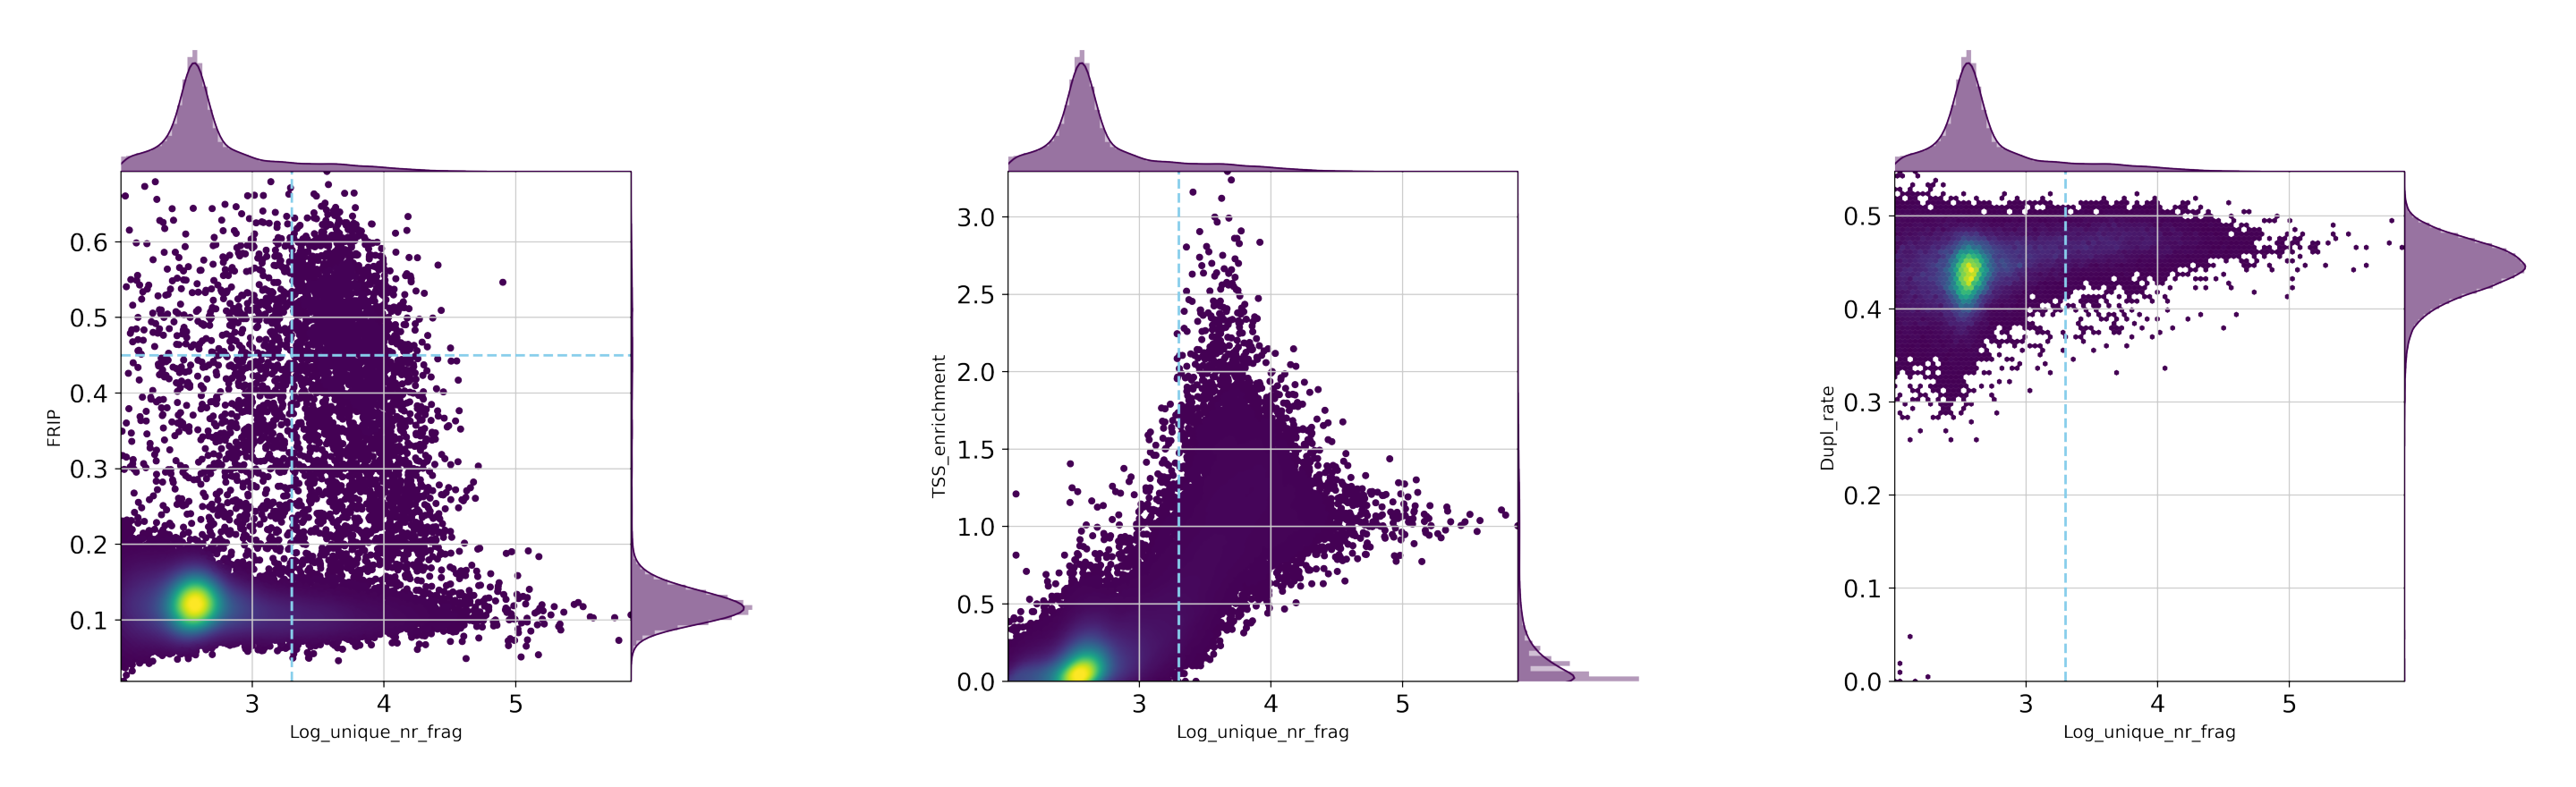

In [36]:
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

### Export filtered barcodes

In [38]:
bc_passing_filters = {'KDM6A_wt_40':[]}
bc_passing_filters['KDM6A_wt_40'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, '/mnt/LaCIE/carlos/nobackup/raw_data/single_cell/external/collaborations/becker_2023/atac/consensus_peak_calling/quality_control/KDM6A_wt_40_bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['KDM6A_wt_40'])} barcodes passed QC stats")

0 barcodes passed QC stats


### Select HVGs

In [ ]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)
adata

### Transfer of annotation with scANVI

In [ ]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "sample", 
                            categorical_covariate_keys = ["sample"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

In [ ]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [ ]:
scvi_model.train(30, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 use_gpu = 1)

In [ ]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [ ]:
scanvi_model.train(20, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   use_gpu = 1)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'magma')

### Modify object to plot canonical marker genes

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI', 'Ttn', 'Nppa', 'Dcn', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'RdPu')

### Visualise proportions

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
bauhaus_colors = ['#FF0000', '#FFFF00', '#000000', '#4D5D53', '#0000FF', '#808080']
sc.pl.umap(adata, frameon = False, color = ['sample'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
df = adata_toplot.obs.groupby(['genotype', 'C_scANVI']).size().reset_index(name = 'counts')

grouped = df.groupby('genotype')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
tab20_palette = plt.cm.get_cmap('tab20', len(df['C_scANVI'].unique()))


for group in df['genotype'].unique():
    temp_df = df[df['genotype'] == group]
    
    data = dict(zip(temp_df['C_scANVI'], temp_df['waffle_counts']))
    colors = [tab20_palette(i) for i in range(len(temp_df['C_scANVI']))]
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 5, 
        values = data, 
        title = {'label': f'Genotype {group}', 'loc': 'left', 'fontsize': 14},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df['C_scANVI'], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0, 'fontsize': 14},
        figsize = (40, 4),
        colors = colors
    )
    plt.show()

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export